In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from qiskit import IBMQ
import sklearn.datasets as skd
from sklearn.model_selection import train_test_split
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.providers.ibmq import least_busy
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from sklearn.datasets import make_blobs
import math

In [2]:
ds = pd.read_csv('heart.csv')
ds.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<AxesSubplot:xlabel='output', ylabel='count'>

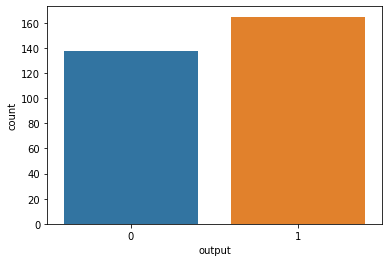

In [3]:
sns.countplot(x = 'output', data =ds)

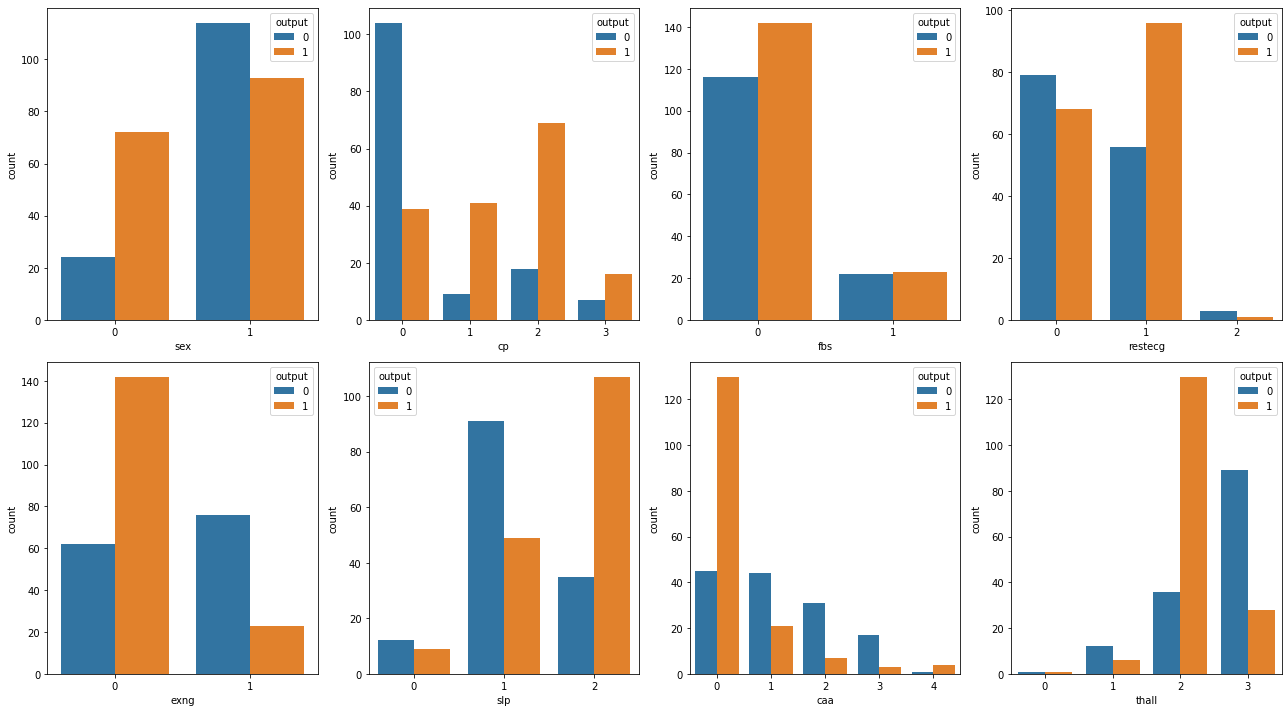

In [4]:
plt.figure(figsize=(18,10))
col = ['sex', 'cp', 'fbs', 'restecg','exng', 'slp', 'caa', 'thall',]
c = 1
for i in col:
    if c < 9:
        plt.subplot(2,4,c)
        sns.countplot(x = i,data =ds,hue = 'output')
        plt.xlabel(i)
    c += 1
    plt.tight_layout()

In [5]:
#defining dependent and independent variables
X = ds.drop('output', axis=1)
y = ds['output']

In [6]:
# X, _, y, _ = train_test_split(X, y, test_size=0.5,  shuffle=True, random_state=42)

In [7]:
X.shape

(303, 13)

In [8]:
# X = X.values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)


In [9]:
X

array([[ 0.9521966 ,  0.68100522,  1.97312292, ..., -2.27457861,
        -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, ..., -2.27457861,
        -0.71442887, -0.51292188],
       [-1.47415758, -1.46841752,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       ...,
       [ 1.50364073,  0.68100522, -0.93851463, ..., -0.64911323,
         1.24459328,  1.12302895],
       [ 0.29046364,  0.68100522, -0.93851463, ..., -0.64911323,
         0.26508221,  1.12302895],
       [ 0.29046364, -1.46841752,  0.03203122, ..., -0.64911323,
         0.26508221, -0.51292188]])

In [10]:
# Rotator
from typing import Callable, List, Optional, Tuple, Union
from math import atan2
def rotate_matrix_nd(bs,degrees):
    ang = np.deg2rad(degrees)
    dim = np.shape(bs)[0]
    Rot_mat = np.eye(dim)
    for k in range(0,dim-2):
        for l in range(dim-1,k,-1):
            a = atan2(bs[l,k],bs[l-1,k])
            R = np.eye(dim)
            R_temp = np.array([[np.cos(a),np.sin(a)],[-1*np.sin(a),np.cos(a)]])
            tmp = l - 1
            R[tmp:tmp+R_temp.shape[0],tmp:tmp+R_temp.shape[0]] = R_temp
            bs=np.matmul(R,bs)
            Rot_mat = np.matmul(R,Rot_mat)
    R = np.eye(dim)
    R[dim-2:dim,dim-2:dim] = np.array([[np.cos(ang),-1*np.sin(ang)],[np.sin(ang),np.cos(ang)]])
    Rot_mat = np.matmul(np.linalg.inv(Rot_mat),np.matmul(R,Rot_mat))
    return Rot_mat
#     Rot_mat = np.linalg.lstsq(Rot_mat,np.matmul(R,Rot_mat))
    
    
#     R = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
#     o = np.atleast_2d(origin)
#     p = np.atleast_2d(points)
#     return np.squeeze((R @ (p.T - o.T) + o.T).T)



In [11]:
dim = 13
v = np.logical_or(np.eye(dim),np.fliplr(np.eye(dim))).astype(int)
v = v[:,:-2]
# v = np.eye(dim)[:,:-2]
# v[-2][0] = 1
# v[-1][1] = 1
rot = rotate_matrix_nd(v,-15)

# print(rot)

In [12]:
XX = np.empty((0,dim))
for point in X:
    tmp_point = np.matmul(rot,np.atleast_2d(point).T)
    tmp_point = np.atleast_2d(tmp_point).T
    XX = np.append(XX, tmp_point,axis=0)
XX    

array([[ 0.84386611,  0.78470102,  1.83571009, ..., -2.13716578,
        -0.81812466, -2.04054222],
       [-1.83612886,  0.75148252,  1.10301879, ..., -2.37502033,
        -0.78490616, -0.5921059 ],
       [-1.40748138, -1.48992398,  0.11660727, ...,  0.89177609,
        -0.69292241, -0.57959808],
       ...,
       [ 1.43704203,  0.6608252 , -1.02299239, ..., -0.56463548,
         1.26477331,  1.18962766],
       [ 0.2698416 ,  0.53634742, -0.96467285, ..., -0.62295502,
         0.40974001,  1.14365099],
       [ 0.34479314, -1.42376974,  0.10094597, ..., -0.71802799,
         0.22043443, -0.56725137]])

In [13]:
sample_train, sample_test, label_train, label_test = train_test_split(XX, y, test_size=0.25,  shuffle=True, random_state=42)

In [14]:
sample_train.shape

(227, 13)

# Classic SVM

In [15]:
from sklearn import svm

In [16]:
clf = svm.SVC(gamma='scale')
clf.fit(sample_train, label_train)

SVC()

In [17]:
print(classification_report(label_test, clf.predict(sample_test) , zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        35
           1       0.88      0.90      0.89        41

    accuracy                           0.88        76
   macro avg       0.88      0.88      0.88        76
weighted avg       0.88      0.88      0.88        76



# VQC - Amplitude Encoding Mottonen Method

In [18]:
import funcs

# Training the model

In [19]:
def nextPowerOf2(n):
    p = 1
    if (n and not(n & (n - 1))):
        return n
    while (p < n) :
        p <<= 1     
    return p;

In [20]:
# padding_X = np.zeros((nextPowerOf2(len(X[0])),1))
X = XX
y = y.values

padding_X = 0.3*np.ones((len(X), nextPowerOf2(len(X[0]))-len(X[0])))

X_pad = np.c_[np.c_[X, padding_X], np.zeros((len(X), 0))]
X_pad
print("First X sample (original)  :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X**2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

First X sample (original)  : [ 0.84386611  0.78470102  1.83571009  0.89548967 -0.56804912  2.69281731
 -1.00583187 -0.28293652 -0.38491514  0.95580416 -2.13716578 -0.81812466
 -2.04054222  0.3         0.3         0.3       ]
First X sample (normalized): [ 0.17004435  0.15812221  0.36990717  0.18044682 -0.11446548  0.54261968
 -0.20268147 -0.0570135  -0.07756283  0.19260057 -0.43065239 -0.16485728
 -0.41118214  0.06045189  0.06045189  0.06045189]


In [21]:
# number of qubits
n = 4
num_qubits = n # needed for D&C

# angles for state preparation are new features; impute nans
features = np.array([funcs.get_angles(x, n) for x in X_norm])
features = np.nan_to_num(features)

# divide and conquer
#features = np.array([recursive_compute_beta(x, betas=[]) for x in X_norm])

In [22]:
# set random seed
np.random.seed(42)

# number of samples
num_data = len(y) # 100

# number of training samples
num_train = int(0.75*num_data) # 75

# randomly split into train, validation sets
# index = np.random.permutation(range(num_data))
# feats_train = features[index[:num_train]]
# Y_train = y[index[:num_train]]
# feats_val = features[index[num_train:]]
# Y_val = y[index[num_train:]]

feats_train, feats_val, Y_train, Y_val = train_test_split(features, y, test_size=0.25,  shuffle=True, random_state=42)

# We need these later for plotting
# X_train = X[index[:num_train]]
# X_val = X[index[num_train:]]




In [23]:
# number of parameterized layers
layers = 5 #1
batch_size = 20
iterations = 20

# initial parameters
params_init = np.random.randn(layers, n, 3)*0.01
bias_init = 0.01
learning_rate = 0.01
momentum = 0.1

# set backend to run 
backend = Aer.get_backend('qasm_simulator')

# train model
var, bias, Y_val, pred_val = funcs.train_model(n, layers, params_init, bias_init, batch_size, learning_rate, momentum, iterations, feats_train, Y_train, feats_val, Y_val, features, y)

Iter:     1 | Loss: 1.5671648 | Acc train: 0.5066079 | Acc validation: 0.4605263 

 --------------------------------TEST SET----------------------------------
               precision    recall  f1-score   support

           0       0.46      0.97      0.62        35
           1       0.50      0.02      0.05        41

    accuracy                           0.46        76
   macro avg       0.48      0.50      0.34        76
weighted avg       0.48      0.46      0.31        76
 
--------------------------------------------------------------------------

 --------------------------------TRAIN SET----------------------------------
               precision    recall  f1-score   support

           0       0.48      0.98      0.64       103
           1       0.88      0.11      0.20       124

    accuracy                           0.51       227
   macro avg       0.68      0.55      0.42       227
weighted avg       0.70      0.51      0.40       227
 
------------------------------

/home/nemo/anaconda3/envs/qiskit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iter:    18 | Loss: 1.1594215 | Acc train: 0.5462555 | Acc validation: 0.5394737 

 --------------------------------TEST SET----------------------------------
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.54      1.00      0.70        41

    accuracy                           0.54        76
   macro avg       0.27      0.50      0.35        76
weighted avg       0.29      0.54      0.38        76
 
--------------------------------------------------------------------------

 --------------------------------TRAIN SET----------------------------------
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.55      1.00      0.71       124

    accuracy                           0.55       227
   macro avg       0.27      0.50      0.35       227
weighted avg       0.30      0.55      0.39       227
 
------------------------------

In [28]:
print(classification_report(Y_val, pred_val))

              precision    recall  f1-score   support

           0       0.49      0.89      0.63        35
           1       0.69      0.22      0.33        41

    accuracy                           0.53        76
   macro avg       0.59      0.55      0.48        76
weighted avg       0.60      0.53      0.47        76



In [353]:
Y_val

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1])

In [354]:
pred_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])